### Installing Necessary Libraries

Here we install all the necessary libraries required for Setting Up Vision Transformer with Relative Positional Encoding. We rely on an existing implementation of image RPE [here](https://github.com/microsoft/Cream/tree/main/iRPE/DETR-with-iRPE).

In [1]:
%%capture
# iRPE
!git clone https://github.com/RishiDarkDevil/ViT-RPE.git # clone if already not cloned
%cd ViT-RPE/iRPE/DETR-with-iRPE
!pip install -r ./requirements.txt

# iRPE for CUDA
%cd rpe_ops
!python setup.py install --user
%cd ..

### Import Libraries

In [33]:
# General
import requests
import argparse
from io import BytesIO

# Matrix Manipulation
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# COCO Data Handling
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from datasets.coco import convert_coco_poly_to_mask
from datasets.coco import ConvertCocoPolysToMask
from util.misc import nested_tensor_from_tensor_list

# Model Output Processing
from models.detr import PostProcess

# Image Processing
import cv2
from PIL import Image
import datasets.transforms as T

# Model Building
import torch
from models import build_model
from models.backbone import build_backbone
from models.transformer import build_transformer
from models.detr import DETR
from models.segmentation import DETRsegm
from models.transformer import RPE_HELP

### Evaluation

Set some parameters below.

In [4]:
DEVICE = 'cuda' # set the device

#### Load Data

Load the image below for evaluation.

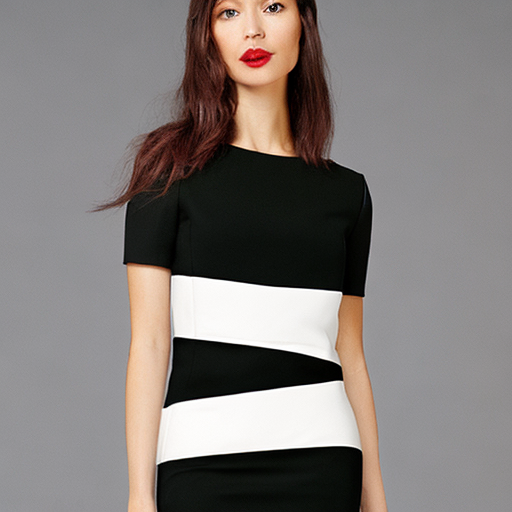

In [118]:
# url = "https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_square.jpg"

# response = requests.get(url)

# init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = Image.open('./Data-Generated/train/22_1.png').convert("RGB")
init_img

In [119]:
# The target associated with each image i.e. the labels, bboxes, masks if any, keypoints, etc used to evaluate the quality of predictions
target = {'image_id': 0, 'annotations': []}
# Creates the object which will prepare our image, target pair
return_masks = False
prepare = ConvertCocoPolysToMask(return_masks)
# Get the image, target pair
img, target = prepare(init_img, target)

We preprocess the image with normalization and resize.

In [120]:
# The normalization transform
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# The set of transformations to be applied on an image as a preprocessing step
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    normalize,
])

In [121]:
# preprocess input image
img, target = transform(init_img, target)
img = nested_tensor_from_tensor_list([img])
img = img.to(DEVICE)

In [122]:
img

tensor([[[[0.1426, 0.1426, 0.1426,  ..., 0.0398, 0.0227, 0.0056],
          [0.1426, 0.1426, 0.1597,  ..., 0.0398, 0.0398, 0.0227],
          [0.1426, 0.1597, 0.1768,  ..., 0.0569, 0.0569, 0.0569],
          ...,
          [0.4337, 0.4337, 0.4166,  ..., 0.2967, 0.3309, 0.3481],
          [0.4508, 0.4337, 0.4166,  ..., 0.3309, 0.3481, 0.3481],
          [0.4508, 0.4337, 0.4166,  ..., 0.3652, 0.3481, 0.3481]],

         [[0.2577, 0.2577, 0.2577,  ..., 0.1702, 0.1352, 0.1001],
          [0.2752, 0.2752, 0.2927,  ..., 0.1702, 0.1527, 0.1352],
          [0.2927, 0.3102, 0.3277,  ..., 0.1877, 0.1877, 0.1877],
          ...,
          [0.6078, 0.6078, 0.5903,  ..., 0.3978, 0.4328, 0.4678],
          [0.6078, 0.6078, 0.5903,  ..., 0.4328, 0.4503, 0.4503],
          [0.6078, 0.6078, 0.5903,  ..., 0.4503, 0.4503, 0.4503]],

         [[0.5136, 0.5311, 0.5485,  ..., 0.3916, 0.3568, 0.3393],
          [0.5311, 0.5485, 0.5659,  ..., 0.4091, 0.3916, 0.3742],
          [0.5485, 0.5659, 0.5834,  ..., 0

Let's load the arguments for the trained model.

In [123]:
# parse arguments in command line arguments to start train/evaluate the model
def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=100, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # 2D relative position encoding
    parser.add_argument('--enc_rpe2d', default='', type=str,
                        help=RPE_HELP)

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset_file', default='coco')
    parser.add_argument('--coco_path', type=str)
    parser.add_argument('--max_class_id', default=90, type=int,
                        help="The maximum class ID of the object annotated")
    parser.add_argument('--val_present', action='store_true',
                        help="If validation set is present or not")
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=4, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    return parser

In [124]:
parser = argparse.ArgumentParser('DETR evaluation', parents=[get_args_parser()])
# Load the arguments for evaluation
args = parser.parse_args('--lr_drop 40 --epochs 50 --coco_path ./Data-Generated --max_class_id 1137 --enc_rpe2d rpe-2.0-product-ctx-1-k --output_dir ./output --eval --resume ./output/checkpoint.pth'.split())

#### Connect Google Drive

To get access to the trained model which is saved in the `output` folder.

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
%cd /content/drive/MyDrive/AIISC-Internship/text-based-object-discovery

/content/drive/MyDrive/AIISC-Internship/text-based-object-discovery


In [20]:
ls

Caption-Processing/   Data-Generated/  POS-Tagger-Comparison/
Caption-Processing1/  LAION/           Results/
Data/                 output/          ViT-RPE/


In [21]:
ls output

checkpoint0039.pth  checkpoint.pth  log.txt


Initialize Model

In [125]:
num_classes = 1137 # Since COCO has max_obj_id = 90 and num_classes = max_obj_id + 1

backbone = build_backbone(args) # initialize backbone

transformer = build_transformer(args) # initialize transformer

model = DETR( #initialize model
    backbone,
    transformer,
    num_classes=num_classes,
    num_queries=args.num_queries,
    aux_loss=args.aux_loss,
)

# model = DETRsegm(model, freeze_detr=(args.frozen_weights is not None))

model = model.to(DEVICE)

# set model for evaluation
model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The number of buckets on rpe_k in encoder: 81


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): RPEMultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
            (rpe_k): iRPE(head_dim=32, num_heads=1, mode="contextual", method=3, transposed=True, num_buckets=81, initializer=<function iRPE.__init__.<locals>.initializer at 0x7f7d107543a0>, rpe_config={'shared_head': True, 'mode': 'contextual', 'method': 3, 'alpha': 2.0, 'beta': 4.0, 'gamma': 16.0, 'num_buckets': 81})
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
        

In [57]:
model.load_state_dict(torch.load('./output/checkpoint.pth')['model'])

<All keys matched successfully>

Here we will run the evaluation on the trained `DETR-with-iRPE` model.

In [126]:
with torch.no_grad():
  outputs = model(img)

In [127]:
outputs

{'pred_logits': tensor([[[ 0.5574,  0.3229, -0.4519,  ..., -0.5468,  0.4573,  0.4594],
          [ 0.5504,  0.3281, -0.4616,  ..., -0.5311,  0.4675,  0.4531],
          [ 0.5492,  0.3115, -0.4549,  ..., -0.5338,  0.4721,  0.4515],
          ...,
          [ 0.5551,  0.3270, -0.4519,  ..., -0.5382,  0.4702,  0.4440],
          [ 0.5574,  0.3201, -0.4585,  ..., -0.5464,  0.4659,  0.4474],
          [ 0.5367,  0.3175, -0.4546,  ..., -0.5404,  0.4742,  0.4585]]],
        device='cuda:0'),
 'pred_boxes': tensor([[[0.4366, 0.5828, 0.5292, 0.5413],
          [0.4368, 0.5832, 0.5297, 0.5412],
          [0.4362, 0.5832, 0.5300, 0.5412],
          [0.4363, 0.5832, 0.5303, 0.5409],
          [0.4370, 0.5835, 0.5296, 0.5405],
          [0.4367, 0.5833, 0.5296, 0.5412],
          [0.4366, 0.5834, 0.5298, 0.5411],
          [0.4361, 0.5833, 0.5304, 0.5411],
          [0.4361, 0.5836, 0.5298, 0.5412],
          [0.4359, 0.5837, 0.5307, 0.5413],
          [0.4368, 0.5831, 0.5302, 0.5408],
          [0

In [128]:
import gc
# Frees up GPU to help reduce memory leak
def optimize_gpu():
  # Reset Already occupied Memory and Cache
  torch.cuda.reset_max_memory_allocated()
  torch.cuda.reset_max_memory_cached()
  torch.cuda.empty_cache()

  # Garbage Collection
  gc.collect()
optimize_gpu()

In [129]:
target

{'boxes': tensor([], size=(0, 4)),
 'labels': tensor([], dtype=torch.int64),
 'image_id': tensor([0]),
 'area': tensor([]),
 'iscrowd': tensor([]),
 'orig_size': tensor([512, 512]),
 'size': tensor([800, 800])}

In [130]:
# orig_target_sizes, below, is tensor of dimension [batch_size x 2] containing the size of each images of the batch
# For evaluation, this must be the original image size (before any data augmentation)
# For visualization, this should be the image size after data augment, but before padding
orig_target_sizes = torch.stack([t["size"].to(DEVICE) for t in [target]], dim=0)

# the boxes are in xyxy format
results = PostProcess()(outputs, orig_target_sizes)

In [131]:
def non_max_suppression(P : torch.tensor ,thresh_iou : float):
  """
  Apply non-maximum suppression to avoid detecting too many
  overlapping bounding boxes for a given object.
  Args:
      boxes: (tensor) The location preds for the image 
          along with the class predscores, Shape: [num_boxes,5].
      thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
  Returns:
      A list of filtered boxes, Shape: [ , 5]
  """

  # we extract coordinates for every 
  # prediction box present in P
  x1 = P[:, 0]
  y1 = P[:, 1]
  x2 = P[:, 2]
  y2 = P[:, 3]

  # we extract the confidence scores as well
  scores = P[:, 4]

  # calculate area of every block in P
  areas = (x2 - x1) * (y2 - y1)
    
  # sort the prediction boxes in P
  # according to their confidence scores
  order = scores.argsort()

  # initialise an empty list for 
  # filtered prediction boxes
  keep = []
    

  while len(order) > 0:
        
    # extract the index of the 
    # prediction with highest score
    # we call this prediction S
    idx = order[-1]

    # push S in filtered predictions list
    keep.append(P[idx])

    # remove S from P
    order = order[:-1]

    # sanity check
    if len(order) == 0:
      break
      
    # select coordinates of BBoxes according to 
    # the indices in order
    xx1 = torch.index_select(x1,dim = 0, index = order)
    xx2 = torch.index_select(x2,dim = 0, index = order)
    yy1 = torch.index_select(y1,dim = 0, index = order)
    yy2 = torch.index_select(y2,dim = 0, index = order)

    # find the coordinates of the intersection boxes
    xx1 = torch.max(xx1, x1[idx])
    yy1 = torch.max(yy1, y1[idx])
    xx2 = torch.min(xx2, x2[idx])
    yy2 = torch.min(yy2, y2[idx])

    # find height and width of the intersection boxes
    w = xx2 - xx1
    h = yy2 - yy1
      
    # take max with 0.0 to avoid negative w and h
    # due to non-overlapping boxes
    w = torch.clamp(w, min=0.0)
    h = torch.clamp(h, min=0.0)

    # find the intersection area
    inter = w*h

    # find the areas of BBoxes according the indices in order
    rem_areas = torch.index_select(areas, dim = 0, index = order) 

    # find the union of every prediction T in P
    # with the prediction S
    # Note that areas[idx] represents area of S
    union = (rem_areas - inter) + areas[idx]
      
    # find the IoU of every prediction in P with S
    IoU = inter / union

    # keep the boxes with IoU less than thresh_iou
    mask = IoU < thresh_iou
    order = order[mask]
    
  return keep

In [102]:
results

[{'scores': tensor([0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121,
          0.0121], device='cuda:0'),
  'labels': tensor([29, 29, 29, 29, 29, 29, 29, 29,

In [29]:
NMS_THRESH = 0.5
nms_results = list()

for det in results:
  P = torch.concatenate([det['boxes'], det['scores'][:,None]], axis=-1)
  keep = non_max_suppression(P, NMS_THRESH)
  nms_results.append({k:v[keep] for k,v in det.items()})

IndexError: ignored

In [30]:
keep

[tensor([2.1823e+02, 2.2020e+02, 6.0794e+02, 6.0309e+02, 6.0478e-03],
        device='cuda:0')]

In [132]:
# The set of transformations to be applied on an image as a preprocessing step 
# For visualization normalization is removed
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
])

img = transform(init_img, target)[0]

In [133]:
pred_boxes = results[0]['boxes'].cpu()

In [134]:
result = img.permute(1,2,0).numpy().copy()
height, width = result.shape[:2]
for bbox in pred_boxes.numpy():
  x1, y1, x2, y2 = bbox
  cv2.rectangle(result, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)

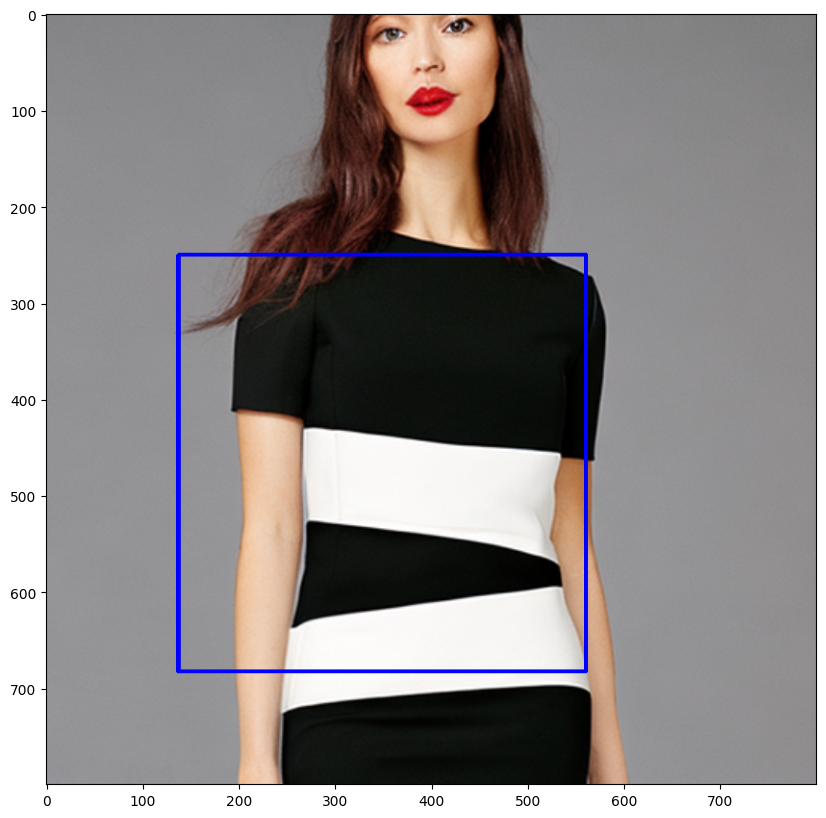

In [135]:
plt.figure(figsize=(10,10))
plt.imshow(result)

In [136]:
results

[{'scores': tensor([0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0039, 0.0039, 0.0040,
          0.0039, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
          0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
          0.0039, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
          0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
          0.0040, 0.0040, 0.0040, 0.0040, 0.0039, 0.0040, 0.0040, 0.0040, 0.0039,
          0.0040, 0.0040, 0.0040, 0.0039, 0.0039, 0.0040, 0.0040, 0.0040, 0.0040,
          0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0039, 0.0040, 0.0040, 0.0039,
          0.0040, 0.0039, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
          0.0040, 0.0040, 0.0039, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0039,
          0.0040, 0.0039, 0.0040, 0.0039, 0.0039, 0.0040, 0.0039, 0.0040, 0.0040,
          0.0039], device='cuda:0'),
  'labels': tensor([1088, 1088, 1088, 1088, 1088, 1

In [137]:
for cat in ann_file['categories']:
  if cat['id'] == 1088:
    print(cat)

{'supercategory': '', 'id': 1088, 'name': 'level'}


In [34]:
# Convert result data from a numpy array [Nx7] where each row contains {imageID,x1,y1,w,h,score,class} to COCO Anns
# AS OF NOW JUST FOR EXPERIMENTATION TAKING THE IMAGEID TO BE 1, 2, ..

array_results = list()
for id, det in enumerate(results):
  nrows = len(det['labels'])
  arr = np.zeros((nrows, 7))
  arr[:,0] = id + 1
  arr[:,1:3] = (det['boxes'][:,:2]).numpy()
  arr[:,3:5] = (det['boxes'][:,2:] - det['boxes'][:,:2]).numpy()
  arr[:,5] = (det['scores']).numpy()
  arr[:,6] = (det['labels']).numpy()
  array_results.append(arr)

numpy_results = np.concatenate(array_results)

# Predictions to COCO Format
coco_data = COCO()
coco_data.loadNumpyAnnotations(numpy_results)

ValueError: ignored

In [ ]:
coco_data

In [ ]:
result = img.permute(1,2,0).numpy().copy()
height, width = result.shape[:2]
for bbox in pred_boxes.numpy():
  x1, y1, x2, y2 = bbox
  cv2.rectangle(result, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)

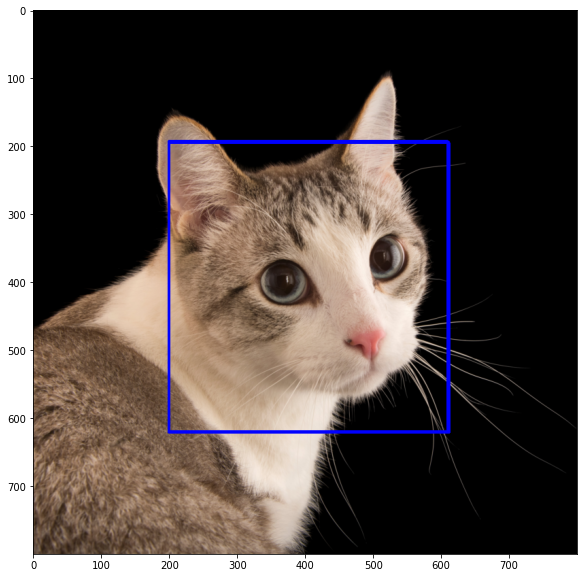

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(result)